#TAREA 2


Integrantes:

*   MESTAS ESCARCENA, CARLOS ALBERTO
*   PRADO CUSSI, DANIEL AUGUSTO
*   FLORES SANTOS, LUCY OLIVIA








Instrucciones de uso:


* Agregar las imágenes en la carpeta principal del notebook del siguiente URL: https://github.com/cmestasescarcena/VisionArtificial-MCC2024/tree/main/Images2


In [ ]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter


Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp43v3vmkx".


## Creación de CSVs

Creación de CSVs con la información de la imagen y del patrón

In [ ]:
import cv2
import numpy as np
import pandas as pd

# Leer las imágenes
image = cv2.imread('imagen.jpg', cv2.IMREAD_GRAYSCALE)
pattern = cv2.imread('patron.jpg', cv2.IMREAD_GRAYSCALE)

# Obtener las dimensiones de las imágenes
image_height, image_width = image.shape
pattern_height, pattern_width = pattern.shape

# Guardar la información en archivos CSV
pd.DataFrame(image).to_csv('imagen.csv', index=False)
pd.DataFrame(pattern).to_csv('patron.csv', index=False)

# Imprimir la información
print(f'Ancho de la imagen: {image_width}, Alto de la imagen: {image_height}')
print(f'Ancho del patrón: {pattern_width}, Alto del patrón: {pattern_height}')


Ancho de la imagen: 309, Alto de la imagen: 213
Ancho del patrón: 96, Alto del patrón: 57


## Procesamiento

In [ ]:
%%cuda
#include <iostream>
#include <vector>
#include <fstream>
#include <sstream>

// Función para calcular la suma de diferencias al cuadrado entre dos regiones de imagen
int sumSquareDifference(const std::vector<std::vector<int>>& image, int startX, int startY,
                        const std::vector<std::vector<int>>& pattern) {
    int sum = 0;
    for (size_t y = 0; y < pattern.size(); ++y) {
        for (size_t x = 0; x < pattern[0].size(); ++x) {
            int diff = pattern[y][x] - image[startY + y][startX + x];
            sum += diff * diff;
        }
    }
    return sum;
}

// Función para encontrar coincidencias entre una imagen y un patrón con un umbral
std::vector<std::pair<int, int>> findMatches(const std::vector<std::vector<int>>& image, const std::vector<std::vector<int>>& pattern, int threshold) {
    std::vector<std::pair<int, int>> matches;

    for (size_t y = 0; y <= image.size() - pattern.size(); ++y) {
        for (size_t x = 0; x <= image[0].size() - pattern[0].size(); ++x) {
            int ssd = sumSquareDifference(image, x, y, pattern);
            //std::cout << "ssd "  << ssd << std::endl;
            if (ssd <= threshold) {
                matches.push_back(std::make_pair(x, y));
            }
        }
    }

    return matches;
}

int main() {
    // Leer la imagen desde el archivo CSV
    std::ifstream imageFile("imagen.csv");
    std::vector<std::vector<int>> image;
    std::string line;

    while (std::getline(imageFile, line)) {
        std::vector<int> row;
        std::stringstream ss(line);
        int value;
        while (ss >> value) {
            row.push_back(value);
            if (ss.peek() == ',') ss.ignore();
        }
        image.push_back(row);
    }

    // Leer el patrón desde el archivo CSV
    std::ifstream patternFile("patron.csv");
    std::vector<std::vector<int>> pattern;

    while (std::getline(patternFile, line)) {
        std::vector<int> row;
        std::stringstream ss(line);
        int value;
        while (ss >> value) {
            row.push_back(value);
            if (ss.peek() == ',') ss.ignore();
        }
        pattern.push_back(row);
    }

    // Umbral para la suma de diferencias al cuadrado
    int threshold = 20000000;

    // Buscar coincidencias
    std::vector<std::pair<int, int>> matches = findMatches(image, pattern, threshold);

    // Guardar coincidencias encontradas en un archivo CSV
    std::ofstream outputFile("coincidencias.csv");
    if (outputFile.is_open()) {
        for (const auto& match : matches) {
            outputFile << match.first << "," << match.second << std::endl;
        }
        outputFile.close();
        std::cout << "Coincidencias guardadas en 'coincidencias.csv'" << std::endl;
    } else {
        std::cerr << "Error al abrir el archivo de salida" << std::endl;
    }

    return 0;
}


Coincidencias guardadas en 'coincidencias.csv'



## Generación de imágenes resultantes


### Imagen original con los puntos de coindicencia encontrados

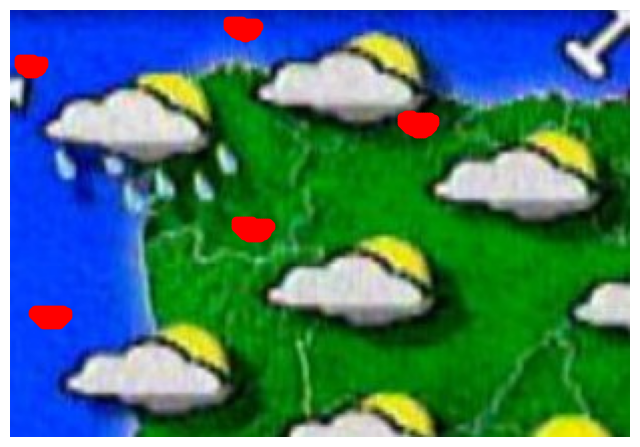

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import csv

# Cargar la imagen
image = cv2.imread('imagen.jpg')

# Leer las posiciones desde el archivo CSV
positions = []
with open('coincidencias.csv', mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        positions.append((int(row[0]), int(row[1])))

# Color para pintar las posiciones (en BGR)
color = (0, 7, 70)  # Verde en este caso

# Pintar las posiciones en la imagen
for pos in positions:
    x, y = pos
    # OpenCV usa (fila, columna), así que invertimos x e y
    image[y, x] = color

# Convertir de BGR a RGB para mostrar con matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen y los puntos dibujados
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
for pos in positions:
    plt.scatter(pos[0], pos[1], color='red', marker='o')  # Mostrar puntos dibujados
plt.axis('off')  # Ocultar ejes
plt.show()

### Imagen con centroides de los grupos de puntos encontrados

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centroide 1: (202, 56)
Centroide 2: (19, 152)
Centroide 3: (120, 108)
Centroide 4: (9, 27)
Centroide 5: (115, 8)


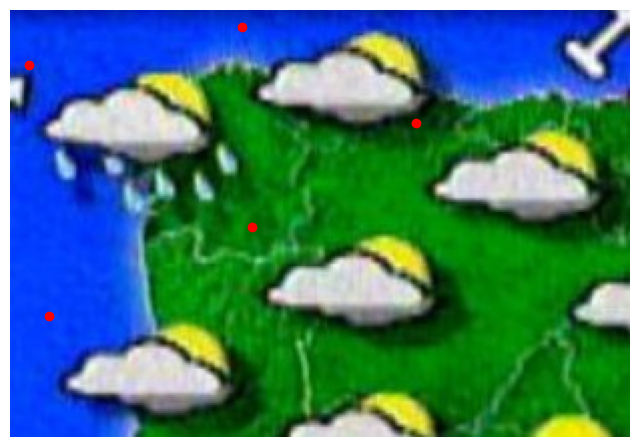

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import csv
from sklearn.cluster import KMeans

# Cargar la imagen
image = cv2.imread('imagen.jpg')

# Leer las posiciones desde el archivo CSV
positions = []
with open('coincidencias.csv', mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        positions.append((int(row[0]), int(row[1])))

# Convertir las posiciones a un formato adecuado para KMeans
X = np.array(positions)

# Número de centroides deseados
num_centroids = 5

# Aplicar KMeans
kmeans = KMeans(n_clusters=num_centroids)
kmeans.fit(X)

# Obtener los centroides de los grupos
centroids = kmeans.cluster_centers_

# Convertir los centroides de nuevo a una lista de tuplas
clustered_points = [tuple(map(int, centroid)) for centroid in centroids]

# Imprimir los centroides
for i, centroid in enumerate(clustered_points):
    print(f"Centroide {i+1}: {centroid}")

# Color para pintar los centroides (en BGR)
centroid_color = (0, 0, 255)  # Rojo en este caso

# Pintar los centroides en la imagen
for centroid in clustered_points:
    x, y = centroid
    # OpenCV usa (fila, columna), así que invertimos x e y
    image[y, x] = centroid_color

# Convertir de BGR a RGB para mostrar con matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con los centroides
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
for centroid in clustered_points:
    plt.scatter(centroid[0], centroid[1], color='red', marker='o')  # Mostrar centroides en rojo
plt.axis('off')  # Ocultar ejes
plt.show()


### Imagen con la ubicación donde se ubica el patrón

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centroide 1: (115, 8)
Centroide 2: (19, 152)
Centroide 3: (120, 108)
Centroide 4: (202, 56)
Centroide 5: (9, 27)


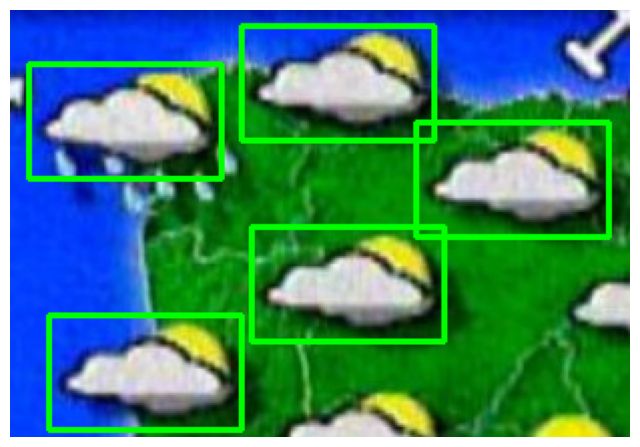

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import csv
from sklearn.cluster import KMeans

# Cargar la imagen
image = cv2.imread('imagen.jpg')

# Leer las posiciones desde el archivo CSV
positions = []
with open('coincidencias.csv', mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        positions.append((int(row[0]), int(row[1])))

# Convertir las posiciones a un formato adecuado para KMeans
X = np.array(positions)

# Número de centroides deseados
num_centroids = 5

# Aplicar KMeans
kmeans = KMeans(n_clusters=num_centroids)
kmeans.fit(X)

# Obtener los centroides de los grupos
centroids = kmeans.cluster_centers_

# Convertir los centroides de nuevo a una lista de tuplas
clustered_points = [tuple(map(int, centroid)) for centroid in centroids]

# Imprimir los centroides
for i, centroid in enumerate(clustered_points):
    print(f"Centroide {i+1}: {centroid}")

# Color para pintar los centroides (en BGR)
centroid_color = (0, 0, 255)  # Rojo en este caso

# Leer las dimensiones del patrón
pattern_image = cv2.imread('patron.jpg')
pattern_height, pattern_width, _ = pattern_image.shape

# Pintar los centroides y los rectángulos en la imagen
for centroid in clustered_points:
    x, y = centroid
    # OpenCV usa (fila, columna), así que invertimos x e y
    image[y, x] = centroid_color
    # Calcular las coordenadas del rectángulo
    rect_x = x
    rect_y = y
    rect_width = pattern_width
    rect_height = pattern_height
    # Dibujar el rectángulo en la imagen
    cv2.rectangle(image, (rect_x, rect_y), (rect_x + rect_width, rect_y + rect_height), (0, 255, 0), 2)

# Convertir de BGR a RGB para mostrar con matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con los centroides y los rectángulos
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()


## Implementación con CUDA

In [ ]:
from PIL import Image
import csv

# Abrir la imagen JPEG
imagen = Image.open('image.jpg')

# Obtener los píxeles de la imagen
pixels = list(imagen.getdata())

# Crear un archivo CSV para escribir los datos de los píxeles
with open('tmp/img-pixels.csv', mode='w', newline='') as archivo_pixels:
    escritor_csv = csv.writer(archivo_pixels)

    # Escribir el encabezado en el archivo CSV
    # escritor_csv.writerow(['R', 'G', 'B'])

    # Escribir los datos de los píxeles en el archivo CSV
    for pixel in pixels:
        escritor_csv.writerow(pixel)

print('Archivo CSV de píxeles generado exitosamente.')

# Crear un archivo CSV para escribir la información del ancho y alto de la imagen
with open('tmp/img-info.csv', mode='w', newline='') as archivo_info:
    escritor_csv = csv.writer(archivo_info)

    # Escribir el encabezado en el archivo CSV
    #escritor_csv.writerow(['Width', 'Height'])

    # Escribir la información del ancho y alto de la imagen en el archivo CSV
    escritor_csv.writerow([imagen.width, imagen.height])

print('Archivo CSV de información de la imagen generado exitosamente.')

Archivo CSV de píxeles generado exitosamente.
Archivo CSV de información de la imagen generado exitosamente.


In [ ]:
from PIL import Image
import csv

# Abrir la imagen JPEG
imagen = Image.open('pattern.jpg')

# Obtener los píxeles de la imagen
pixels = list(imagen.getdata())

# Crear un archivo CSV para escribir los datos de los píxeles
with open('tmp/pattern-pixels.csv', mode='w', newline='') as archivo_pixels:
    escritor_csv = csv.writer(archivo_pixels)

    # Escribir el encabezado en el archivo CSV
    #escritor_csv.writerow(['R', 'G', 'B'])

    # Escribir los datos de los píxeles en el archivo CSV
    for pixel in pixels:
        escritor_csv.writerow(pixel)

print('Archivo CSV de píxeles generado exitosamente.')

# Crear un archivo CSV para escribir la información del ancho y alto de la imagen
with open('tmp/pattern-info.csv', mode='w', newline='') as archivo_info:
    escritor_csv = csv.writer(archivo_info)

    # Escribir el encabezado en el archivo CSV
    #escritor_csv.writerow(['Width', 'Height'])

    # Escribir la información del ancho y alto de la imagen en el archivo CSV
    escritor_csv.writerow([imagen.width, imagen.height])

print('Archivo CSV de información de la imagen generado exitosamente.')

Archivo CSV de píxeles generado exitosamente.
Archivo CSV de información de la imagen generado exitosamente.


In [ ]:
%%cuda
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>
#include <cuda_runtime.h>

__global__ void templateMatching(const unsigned char* image, const unsigned char* pattern,
                                 int* diffSums, int imageWidth, int imageHeight,
                                 int patternWidth, int patternHeight) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < imageWidth - patternWidth && y < imageHeight - patternHeight) {
        int sum = 0;
        for (int i = 0; i < patternHeight; ++i) {
            for (int j = 0; j < patternWidth; ++j) {
                int imageIdx = (y + i) * imageWidth + (x + j);
                int patternIdx = i * patternWidth + j;
                int diff = image[imageIdx] - pattern[patternIdx];
                sum += diff * diff;
            }
        }
        diffSums[y * (imageWidth - patternWidth) + x] = sum;
    }
}

int main() {
    std::ifstream imageFile("tmp/img-pixels.csv");
    std::ifstream patternFile("tmp/pattern-pixels.csv");

    if (!imageFile.is_open() || !patternFile.is_open()) {
        std::cerr << "Error opening files." << std::endl;
        return 1;
    }

    std::vector<unsigned char> imagePixels;
    std::vector<unsigned char> patternPixels;

    std::string line;
    bool firstLine = true;
    while (std::getline(imageFile, line)) {
        if (firstLine) {
            firstLine = false;
            continue;
        }
        std::istringstream iss(line);
        std::string token;
        while (std::getline(iss, token, ',')) {
            imagePixels.push_back(static_cast<unsigned char>(std::stoi(token)));
        }
    }
    imageFile.close();

    while (std::getline(patternFile, line)) {
        std::istringstream iss(line);
        std::string token;
        while (std::getline(iss, token, ',')) {
            patternPixels.push_back(static_cast<unsigned char>(std::stoi(token)));
        }
    }
    patternFile.close();

    const int imageWidth = 309;
    const int imageHeight = 213;
    const int patternWidth = 96;
    const int patternHeight = 57;

    int* d_diffSums;
    cudaMalloc(&d_diffSums, (imageWidth - patternWidth) * (imageHeight - patternHeight) * sizeof(int));

    unsigned char* d_imagePixels;
    cudaMalloc(&d_imagePixels, imagePixels.size() * sizeof(unsigned char));
    cudaMemcpy(d_imagePixels, imagePixels.data(), imagePixels.size() * sizeof(unsigned char), cudaMemcpyHostToDevice);

    unsigned char* d_patternPixels;
    cudaMalloc(&d_patternPixels, patternPixels.size() * sizeof(unsigned char));
    cudaMemcpy(d_patternPixels, patternPixels.data(), patternPixels.size() * sizeof(unsigned char), cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize((imageWidth - patternWidth + blockSize.x - 1) / blockSize.x, (imageHeight - patternHeight + blockSize.y - 1) / blockSize.y);

    templateMatching<<<gridSize, blockSize>>>(d_imagePixels, d_patternPixels, d_diffSums,
                                              imageWidth, imageHeight, patternWidth, patternHeight);

    int* diffSums = new int[(imageWidth - patternWidth) * (imageHeight - patternHeight)];
    cudaMemcpy(diffSums, d_diffSums, (imageWidth - patternWidth) * (imageHeight - patternHeight) * sizeof(int), cudaMemcpyDeviceToHost);

    const int threshold = 1000;
    int minSum = diffSums[0];
    int minX = 0, minY = 0;
    for (int y = 0; y < imageHeight - patternHeight; ++y) {
        for (int x = 0; x < imageWidth - patternWidth; ++x) {
            int sum = diffSums[y * (imageWidth - patternWidth) + x];
            if (sum < minSum) {
                minSum = sum;
                minX = x;
                minY = y;
            }
        }
    }

    if (minSum < threshold) {
        std::cout << "Patrón encontrado en la posición (" << minX << ", " << minY << ")" << std::endl;
    } else {
        std::cout << "Patrón no encontrado." << std::endl;
    }

    cudaFree(d_diffSums);
    cudaFree(d_imagePixels);
    cudaFree(d_patternPixels);
    delete[] diffSums;

    return 0;
}


Patrón no encontrado.

